In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

from nbodykit.lab import cosmology

import scipy
from scipy import optimize
import pandas as pd

import george
from george import kernels

### Load in data

In [2]:
boxsize = 750
nbar_str = '1e-4'
seed = 0
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)

In [3]:
data_fn = '{}/cat_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
data = np.loadtxt(data_fn)
#nd = data.shape[0]
datasky_fn = '{}/catsky_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
datasky = np.loadtxt(datasky_fn).T

In [4]:
datadf = pd.DataFrame(data, columns=['x','y','z'])

In [5]:
rand_fn = '{}/rand{}_10x.dat'.format(cat_dir, cat_tag)
random = np.loadtxt(rand_fn)
#nr = random.shape[0]
randsky_fn = '{}/randsky{}_10x.dat'.format(cat_dir, cat_tag)
randomsky = np.loadtxt(randsky_fn)

In [6]:
randdf = pd.DataFrame(random, columns=['x','y','z'])

### Make up some systematics

In [7]:
def normalize(w):
    wmin = min(w)
    wspread = max(w) - min(w)
    return (w-wmin)/wspread

In [8]:
def sys1(x, y, z):
    #return 1-0.0002*x
    return normalize(x)
    #return np.random.random(len(x))

In [9]:
datadf['s1'] = sys1(datadf['x'], datadf['y'], datadf['z'])
randdf['s1'] = sys1(randdf['x'], randdf['y'], randdf['z'])

Systematic 1 is just a linear dependence on x position:

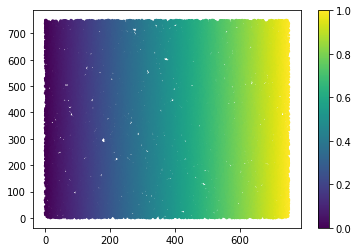

In [10]:
plt.scatter(datadf['x'], datadf['y'], s=4, c=datadf['s1'])
plt.colorbar()

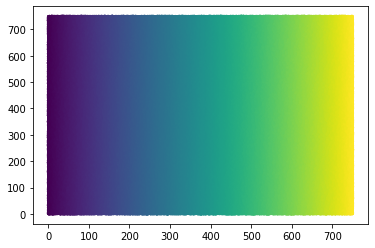

In [11]:
plt.scatter(randdf['x'], randdf['y'], s=4, c=randdf['s1'])

This function calculates the ratio bw the number density of galaxies and randoms, as a function of a systematic. If there was no dependence on the systematic, this should be one (with random noise).

This can also apply correction weights.

In [12]:
def calc_systematic_dist(ddf, rdf, sys_name, nbins=16, xlabel='', correction_weight_name=None, correction_fit=None):

    gpsfi = ddf[sys_name]
    grbins = np.arange(min(gpsfi), max(gpsfi), (max(gpsfi)-min(gpsfi))/nbins)
    gnum, gbins, gpatches = plt.hist(gpsfi, grbins, color='blue', alpha=0.5)

    rpsfi = rdf[sys_name]
    rnum, rbins, rpatches = plt.hist(rpsfi, grbins, color='yellow', alpha=0.5)
    
    #plt.hist(gpsfi, grbins, color='blue', alpha=0.3, normed=True)
    #plt.hist(rpsfi, grbins, color='orange', alpha=0.3, normed=True)
    
    gnumdens = gnum/len(ddf)
    rnumdens = rnum/len(rdf)
    gal2rand = gnumdens/rnumdens
    barbins = grbins[:-1]
    #plt.bar(barbins, gal2rand, width=grbins[1]-grbins[0])
    
    if correction_weight_name is not None:
        gnum_corr, gbins_corr, gpatches_corr = plt.hist(gpsfi, grbins, color='blue', alpha=0.5, 
                                                        weights=ddf[correction_weight_name])
        gnumdens_corr = gnum_corr/len(ddf)
        gal2rand_corr = gnumdens_corr/rnumdens
        
    plt.clf()
    #weights, myfit = correct(barbins, gal2rand)
    
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(barbins, gal2rand, ls='-', marker='o', color='black', label='initial')
    
    if correction_weight_name is not None:
        ax.plot(barbins, gal2rand_corr, ls='-', marker='o', color='blue', label=f'corrected ({correction_weight_name})')
    
    #ax.errorbar(barbins, poisson)
    #ax.plot(barbins, gnumdens, ls='-', marker='o', color='black')
    
    #ax.plot(barbins, myfit, color='magenta', label='fit')
    if correction_fit is not None:
        ax.plot(barbins, correction_fit(barbins), color='magenta', label='fit')        
        ax.plot(barbins, 1./correction_fit(barbins)*gal2rand, color='cyan', label='weighted')
    #if xlabel=='':
    #    xlabel=param
    #ax.set_xlabel(xlabel)
    ax.axhline(1, ls=':', color='grey')
    
    ax.set_ylabel(r'n$_{gal}$/n$_{rand}$')
    plt.legend(loc='best')
    
    return barbins, gal2rand

This function subsamples the galaxy density as a function of some systematic. The function is given by "downfunc" - this is how we can introduce nonlinearities.

In [13]:
def subsample(ddf, weight_name, downfunc):
    sel = [np.random.random() for _ in range(len(ddf))]
    ww = downfunc(ddf[weight_name])
    #sub = np.array([vals[:, i] for i in range(len(ddf)) if sel[i]<ww[i]]).T
    subdf = ddf[sel < ww]
    #wsub = [weights[i] for i in range(len(vals[0])) if sel[i]<ww[i]]
    return subdf

In [14]:
def linear(x):
    return 1-0.2*x

Let's make another systematic, this one totally random:

In [15]:
def sys2(x, y, z):
    return np.random.random(len(x))

In [16]:
datadf['s2'] = sys2(datadf['x'], datadf['y'], datadf['z'])
randdf['s2'] = sys2(randdf['x'], randdf['y'], randdf['z'])

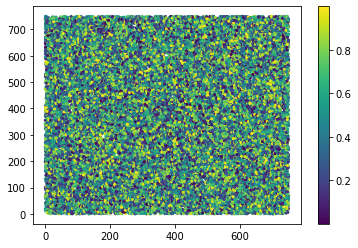

In [17]:
plt.scatter(datadf['x'], datadf['y'], s=4, c=datadf['s2'])
plt.colorbar()

These functions determine how to correct for the downsampling using weights.

In [18]:
def correct_linear(bins, gal2rand):
    fit = np.polyfit(bins, gal2rand, 1)
    p1d = np.poly1d(fit)
    def corrfit(x):
        return p1d(x)
    return corrfit

def correct_gp(bins, gal2rand):

    kernel = kernels.ExpSquaredKernel(1.0)
    gp = george.GP(kernel)
    gp.compute(bins)
    
    def corrfit(x):
        pred, _ = gp.predict(gal2rand, x)
        return pred
    return corrfit

Downsample the galaxies based on some combination of the systematics, and some function.

In [19]:
datadf['s12'] = 0.1*datadf['s1']+0.1*datadf['s2'] + 2*datadf['s1']*datadf['s2']
sub12df = subsample(datadf, 's12', downfunc=linear)
print(len(sub12df)/len(datadf))

0.8796573164364706


### Iterative correction

Here we try to correct for the two systematics iteratively.

Sys 1 first:

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 ]),
 array([1.10133484, 1.06369612, 1.17575253, 1.08180266, 1.08536864,
        1.04008901, 1.02023828, 0.95108306, 0.97582864, 0.98709839,
        0.98363724, 0.9683807 , 0.90936634, 0.92084752, 0.89218621]))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

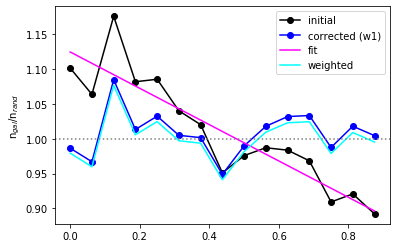

In [20]:
bins1, n1 = calc_systematic_dist(sub12df, randdf, 's1')
corrfit1 = correct_linear(bins1, n1)
sub12df['w1'] = 1./corrfit1(sub12df['s1'])
calc_systematic_dist(sub12df, randdf, 's1', correction_weight_name='w1', correction_fit=corrfit1)

Check out how sys2 is doing with the sys1 corrections.

If uncorrelated, those shouldn't help!

<Figure size 432x288 with 0 Axes>

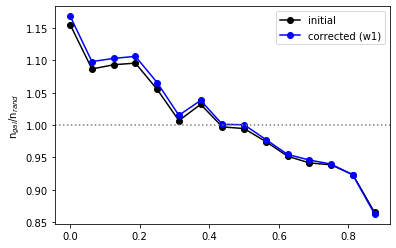

In [41]:
bins2, n2 = calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w1')

Now, with the w2 weight correction:

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([5.30522760e-05, 6.25492177e-02, 1.25045383e-01, 1.87541549e-01,
        2.50037714e-01, 3.12533880e-01, 3.75030045e-01, 4.37526210e-01,
        5.00022376e-01, 5.62518541e-01, 6.25014707e-01, 6.87510872e-01,
        7.50007038e-01, 8.12503203e-01, 8.74999369e-01]),
 array([1.1553909 , 1.08687435, 1.09338986, 1.09592694, 1.05531045,
        1.00701215, 1.03211797, 0.99724772, 0.99464697, 0.97445344,
        0.95182823, 0.94153048, 0.93854603, 0.92344442, 0.86488634]))

<Figure size 432x288 with 0 Axes>

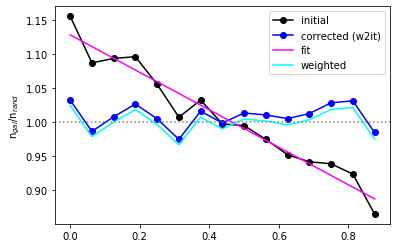

In [43]:
corrfit2 = correct_linear(bins2, n2)
sub12df['w2it'] = 1./corrfit2(sub12df['s2'])
calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w2it', correction_fit=corrfit2)

Compute the combined weights, which should work for both:

In [23]:
sub12df['w12it'] = sub12df['w1']*sub12df['w2it']

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 ]),
 array([1.10025691, 1.06826418, 1.17106693, 1.06561683, 1.08788981,
        1.04000945, 1.01250826, 0.97719861, 0.98961941, 0.97089544,
        0.97498992, 0.98311157, 0.91341441, 0.92404595, 0.8790989 ]))

<Figure size 432x288 with 0 Axes>

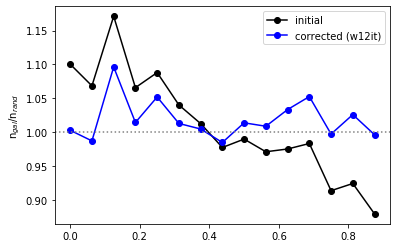

In [24]:
calc_systematic_dist(sub12df, randdf, 's1', correction_weight_name='w12it')

(array([5.30522760e-05, 6.25492177e-02, 1.25045383e-01, 1.87541549e-01,
        2.50037714e-01, 3.12533880e-01, 3.75030045e-01, 4.37526210e-01,
        5.00022376e-01, 5.62518541e-01, 6.25014707e-01, 6.87510872e-01,
        7.50007038e-01, 8.12503203e-01, 8.74999369e-01]),
 array([1.1553909 , 1.08687435, 1.09338986, 1.09592694, 1.05531045,
        1.00701215, 1.03211797, 0.99724772, 0.99464697, 0.97445344,
        0.95182823, 0.94153048, 0.93854603, 0.92344442, 0.86488634]))

<Figure size 432x288 with 0 Axes>

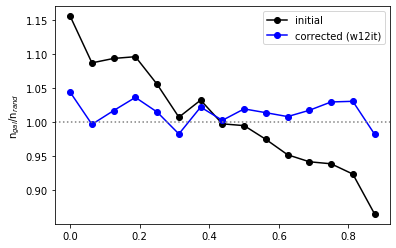

In [25]:
calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w12it')

Check out the final weight mask:

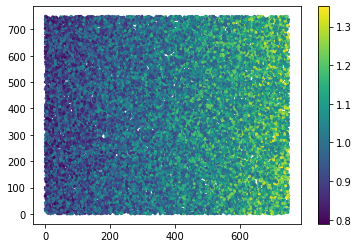

In [26]:
plt.scatter(sub12df['x'], sub12df['y'], s=4, c=sub12df['w12it'])
plt.colorbar()

### Iterative with GPs:

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 ]),
 array([1.10025691, 1.06826418, 1.17106693, 1.06561683, 1.08788981,
        1.04000945, 1.01250826, 0.97719861, 0.98961941, 0.97089544,
        0.97498992, 0.98311157, 0.91341441, 0.92404595, 0.8790989 ]))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

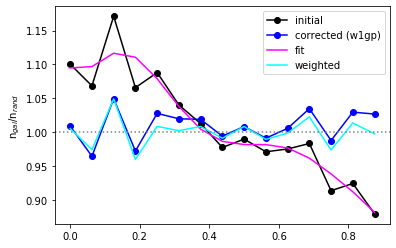

In [44]:
bins1, n1 = calc_systematic_dist(sub12df, randdf, 's1')
corrfit1gp = correct_gp(bins1, n1)
sub12df['w1gp'] = 1./corrfit1gp(sub12df['s1'])
calc_systematic_dist(sub12df, randdf, 's1', correction_weight_name='w1gp', correction_fit=corrfit1gp)


<Figure size 432x288 with 0 Axes>

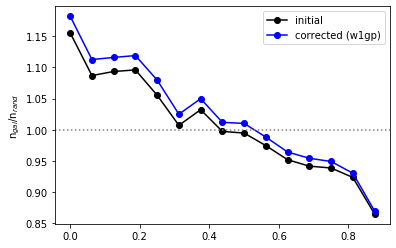

In [45]:
bins2gp, n2gp = calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w1gp')

Uhhhh why is the correction not working here?? Need to do something diff for nonlinear?

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([5.30522760e-05, 6.25492177e-02, 1.25045383e-01, 1.87541549e-01,
        2.50037714e-01, 3.12533880e-01, 3.75030045e-01, 4.37526210e-01,
        5.00022376e-01, 5.62518541e-01, 6.25014707e-01, 6.87510872e-01,
        7.50007038e-01, 8.12503203e-01, 8.74999369e-01]),
 array([1.1553909 , 1.08687435, 1.09338986, 1.09592694, 1.05531045,
        1.00701215, 1.03211797, 0.99724772, 0.99464697, 0.97445344,
        0.95182823, 0.94153048, 0.93854603, 0.92344442, 0.86488634]))

<Figure size 432x288 with 0 Axes>

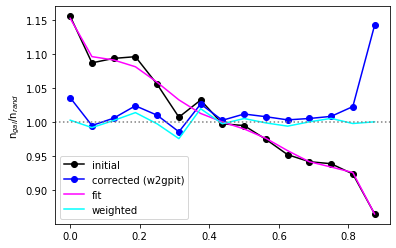

In [46]:
corrfit2gp = correct_gp(bins2gp, n2gp)
sub12df['w2gpit'] = 1./corrfit2gp(sub12df['s2'])
calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w2gpit', correction_fit=corrfit2gp)

In [38]:
#corrfit2gp_lin = correct_linear(bins2gp, n2gp)
#sub12df['w2gpit'] = 1./corrfit2gp_lin(sub12df['s2'])
#calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w2gpit', correction_fit=corrfit2gp_lin)

In [29]:
sub12df['w12gpit'] = sub12df['w1gp']*sub12df['w2gpit']

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 ]),
 array([1.10025691, 1.06826418, 1.17106693, 1.06561683, 1.08788981,
        1.04000945, 1.01250826, 0.97719861, 0.98961941, 0.97089544,
        0.97498992, 0.98311157, 0.91341441, 0.92404595, 0.8790989 ]))

<Figure size 432x288 with 0 Axes>

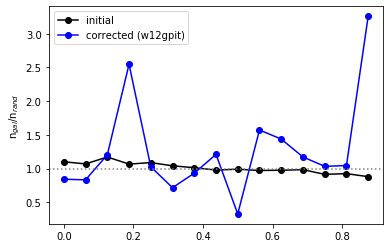

In [30]:
calc_systematic_dist(sub12df, randdf, 's1', correction_weight_name='w12gpit')

(array([5.30522760e-05, 6.25492177e-02, 1.25045383e-01, 1.87541549e-01,
        2.50037714e-01, 3.12533880e-01, 3.75030045e-01, 4.37526210e-01,
        5.00022376e-01, 5.62518541e-01, 6.25014707e-01, 6.87510872e-01,
        7.50007038e-01, 8.12503203e-01, 8.74999369e-01]),
 array([1.1553909 , 1.08687435, 1.09338986, 1.09592694, 1.05531045,
        1.00701215, 1.03211797, 0.99724772, 0.99464697, 0.97445344,
        0.95182823, 0.94153048, 0.93854603, 0.92344442, 0.86488634]))

<Figure size 432x288 with 0 Axes>

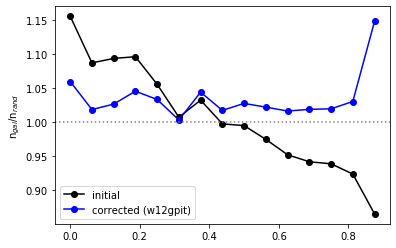

In [31]:
calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w12gpit')

In [32]:
def sin(x):
    return np.sin(50*x)

def cubic(x):
    return 0.95-((1.2*x-0.5))**3 

In [85]:
def correct_gp_2d(bins, gal2rand):

    #kernel = kernels.ExpSquaredKernel(1.0)
    p0 = np.ones(bins.shape[-1])
    kernel = kernels.ExpSquaredKernel(p0, ndim=len(p0))
    gp = george.GP(kernel)
    gp.compute(bins)
    
    def corrfit(x):
        pred, _ = gp.predict(gal2rand, x)
        return pred
    return corrfit

(15, 2)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

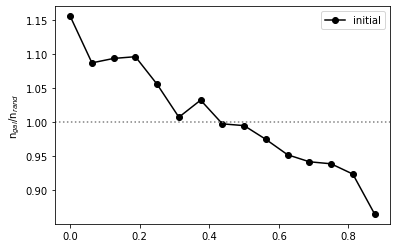

In [90]:
bins1, n1 = calc_systematic_dist(sub12df, randdf, 's1')
bins2, n2 = calc_systematic_dist(sub12df, randdf, 's2')
b = np.array([bins1, bins2]).T
print(b.shape)
n = np.array([n1,n2]).T
corrfit2dgp = correct_gp_2d(b, n1)



In [91]:
sub12df['w2dgp'] = 1./corrfit2dgp(sub12df['s1'])

ValueError: Dimension mismatch

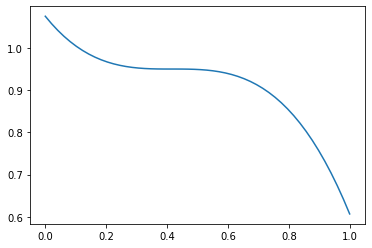

In [33]:
x = np.linspace(0, 1)
plt.plot(x, cubic(x))
#plt.plot(x, sin(x))

In [ ]:
def calc_systematic_dist(ddf, rdf, sys_name, nbins=16, xlabel='', correction_weight_name=None, correction_fit=None):

    gpsfi = ddf[sys_name]
    grbins = np.arange(min(gpsfi), max(gpsfi), (max(gpsfi)-min(gpsfi))/nbins)
    gnum, gbins, gpatches = plt.hist(gpsfi, grbins, color='blue', alpha=0.5)

    rpsfi = rdf[sys_name]
    rnum, rbins, rpatches = plt.hist(rpsfi, grbins, color='yellow', alpha=0.5)
    
    #plt.hist(gpsfi, grbins, color='blue', alpha=0.3, normed=True)
    #plt.hist(rpsfi, grbins, color='orange', alpha=0.3, normed=True)
    
    gnumdens = gnum/len(ddf)
    rnumdens = rnum/len(rdf)
    gal2rand = gnumdens/rnumdens
    barbins = grbins[:-1]
    #plt.bar(barbins, gal2rand, width=grbins[1]-grbins[0])
    
    if correction_weight_name is not None:
        gnum_corr, gbins_corr, gpatches_corr = plt.hist(gpsfi, grbins, color='blue', alpha=0.5, 
                                                        weights=ddf[correction_weight_name])
        gnumdens_corr = gnum_corr/len(ddf)
        gal2rand_corr = gnumdens_corr/rnumdens
        
    plt.clf()
    #weights, myfit = correct(barbins, gal2rand)
    
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(barbins, gal2rand, ls='-', marker='o', color='black', label='initial')
    
    if correction_weight_name is not None:
        ax.plot(barbins, gal2rand_corr, ls='-', marker='o', color='blue', label=f'corrected ({correction_weight_name})')
    
    #ax.errorbar(barbins, poisson)
    #ax.plot(barbins, gnumdens, ls='-', marker='o', color='black')
    
    #ax.plot(barbins, myfit, color='magenta', label='fit')
    if correction_fit is not None:
        ax.plot(barbins, correction_fit(barbins), color='magenta', label='fit')        
        ax.plot(barbins, 1./correction_fit(barbins)*gal2rand, color='cyan', label='weighted')
    #if xlabel=='':
    #    xlabel=param
    #ax.set_xlabel(xlabel)
    ax.axhline(1, ls=':', color='grey')
    
    ax.set_ylabel(r'n$_{gal}$/n$_{rand}$')
    plt.legend(loc='best')
    
    return barbins, gal2rand

In [ ]:

    gpsfi = ddf[sys_name]
    grbins = np.arange(min(gpsfi), max(gpsfi), (max(gpsfi)-min(gpsfi))/nbins)
    gnum, gbins, gpatches = plt.hist(gpsfi, grbins, color='blue', alpha=0.5)

    rpsfi = rdf[sys_name]
    rnum, rbins, rpatches = plt.hist(rpsfi, grbins, color='yellow', alpha=0.5)
    
    gnum_corr, gbins_corr, gpatches_corr = plt.hist(gpsfi, grbins, color='blue', alpha=0.5, 
                                                        weights=ddf[correction_weight_name])
    
    

In [77]:
def linear_fit(params, sys1):
    a1, b = params
    sys1mean = np.mean(sys1)
    sys1std = np.std(sys1)
    t1 = 0
    for i in range(len(sys1)):
        t1 += a1*(sys1[i] - sys1mean)/sys1std
    
    return t1 + b

In [78]:
guess = [1, 1]
args = (np.array(sub12df['s1']))
#args = (1)
res = optimize.minimize(linear_fit, guess, args=args)

In [79]:
print(res)

      fun: -172924162.08229262
 hess_inv: array([[1.70111889e-11, 3.87871265e-06],
       [3.87871265e-06, 1.67331758e+08]])
      jac: array([10.,  0.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 439
      nit: 4
     njev: 107
   status: 2
  success: False
        x: array([-5.08588303e+04, -1.72924162e+08])


In [92]:
datadf['s12'] = 0.1*datadf['s1']+0.1*datadf['s2'] + 2*datadf['s1']*datadf['s2']
sub12df = subsample(datadf, 's12', downfunc=cubic)
print(len(sub12df)/len(datadf))

0.7751673074184822


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
        0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 ]),
 array([1.26695862, 1.23389201, 1.3445261 , 1.25175514, 1.27436942,
        1.23827218, 1.16405524, 1.08559471, 1.03116543, 0.95860904,
        0.85288753, 0.82087644, 0.69577064, 0.65114498, 0.57386817]))

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

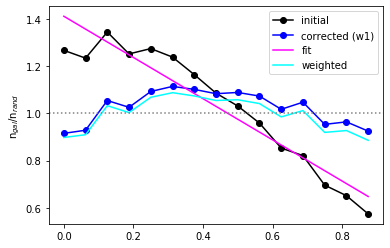

In [93]:
bins1, n1 = calc_systematic_dist(sub12df, randdf, 's1')
corrfit1 = correct_linear(bins1, n1)
sub12df['w1'] = 1./corrfit1(sub12df['s1'])
calc_systematic_dist(sub12df, randdf, 's1', correction_weight_name='w1', correction_fit=corrfit1)

<Figure size 432x288 with 0 Axes>

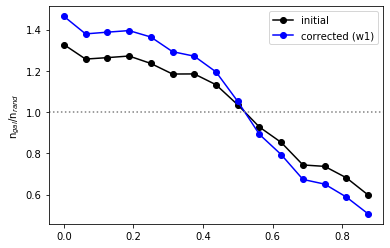

In [94]:
bins2, n2 = calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w1')

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([5.30522760e-05, 6.25492177e-02, 1.25045383e-01, 1.87541549e-01,
        2.50037714e-01, 3.12533880e-01, 3.75030045e-01, 4.37526210e-01,
        5.00022376e-01, 5.62518541e-01, 6.25014707e-01, 6.87510872e-01,
        7.50007038e-01, 8.12503203e-01, 8.74999369e-01]),
 array([1.32773264, 1.25710119, 1.26410359, 1.27194474, 1.23593619,
        1.18456007, 1.18509607, 1.13264935, 1.03518113, 0.92706494,
        0.85267165, 0.74333174, 0.73647676, 0.68088275, 0.59742435]))

<Figure size 432x288 with 0 Axes>

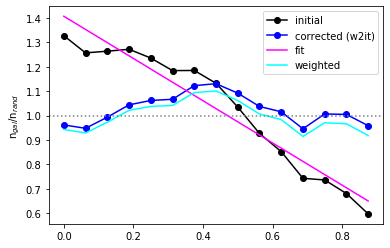

In [95]:
corrfit2 = correct_linear(bins2, n2)
sub12df['w2it'] = 1./corrfit2(sub12df['s2'])
calc_systematic_dist(sub12df, randdf, 's2', correction_weight_name='w2it', correction_fit=corrfit2)